In [1]:
# CAPTCHA Answer Visualization Helper
# This notebook demonstrates how to use the show_answer_points helper to visualize robot's answer points on CAPTCHA images.

# Import required libraries
import os
import sys
from pathlib import Path

import cv2
import dotenv
import numpy as np
from IPython.display import JSON
from matplotlib import pyplot as plt

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

from hcaptcha_challenger import SpatialPathReasoner
from src.hcaptcha_challenger.helper.create_coordinate_grid import (
    create_coordinate_grid,
    FloatRect
)
from src.hcaptcha_challenger.helper.visualize_attention_points import (
    show_answer_points,
    create_comparison_view
)
from src.hcaptcha_challenger.models import (
    ImageAreaSelectChallenge,
    ImageDragDropChallenge,
    PointCoordinate,
    SpatialPath
)

dotenv.load_dotenv()

True

## 1. Image Drag & Drop Challenge Example
Visualize drag paths for puzzle-solving challenges.

In [2]:
# Define the bounding box for coordinate alignment
DEFAULT_BBOX = FloatRect(x=0, y=0, width=501, height=431)

# Path to the spatial helper image
challenge_screenshot = Path("assets/image_drag_drop/20250717190455891095_0_challenge_view.png")

grid_divisions_path = challenge_screenshot.parent.joinpath(
    f'coordinate_grid_{challenge_screenshot.name}'
)
grid_divisions_image = create_coordinate_grid(challenge_screenshot, DEFAULT_BBOX)
plt.imsave(str(grid_divisions_path.resolve()), grid_divisions_image)

Solve the drag&drop challenge

In [3]:
try:
    gic = SpatialPathReasoner(
        gemini_api_key=os.getenv("GEMINI_API_KEY"), model="gemini-2.5-flash"
    )

    # Ignore trace malloc issues
    results = await gic.invoke_async(
        challenge_screenshot=challenge_screenshot,
        grid_divisions=grid_divisions_path,
        constraint_response_schema=True,
    )

    # Example drag & drop answer from the robot
    drag_drop_answer = results.model_dump()
except Exception as err:
    print(f"{err}")
    drag_drop_answer = {
        "challenge_prompt": "Drag the pipe from the right to complete the puzzle",
        "paths": [
            {
                "start_point": {
                    "x": 450,
                    "y": 160
                },
                "end_point": {
                    "x": 250,
                    "y": 220
                }
            }
        ]
    }

In [4]:
# Check results
JSON(drag_drop_answer)

<IPython.core.display.JSON object>

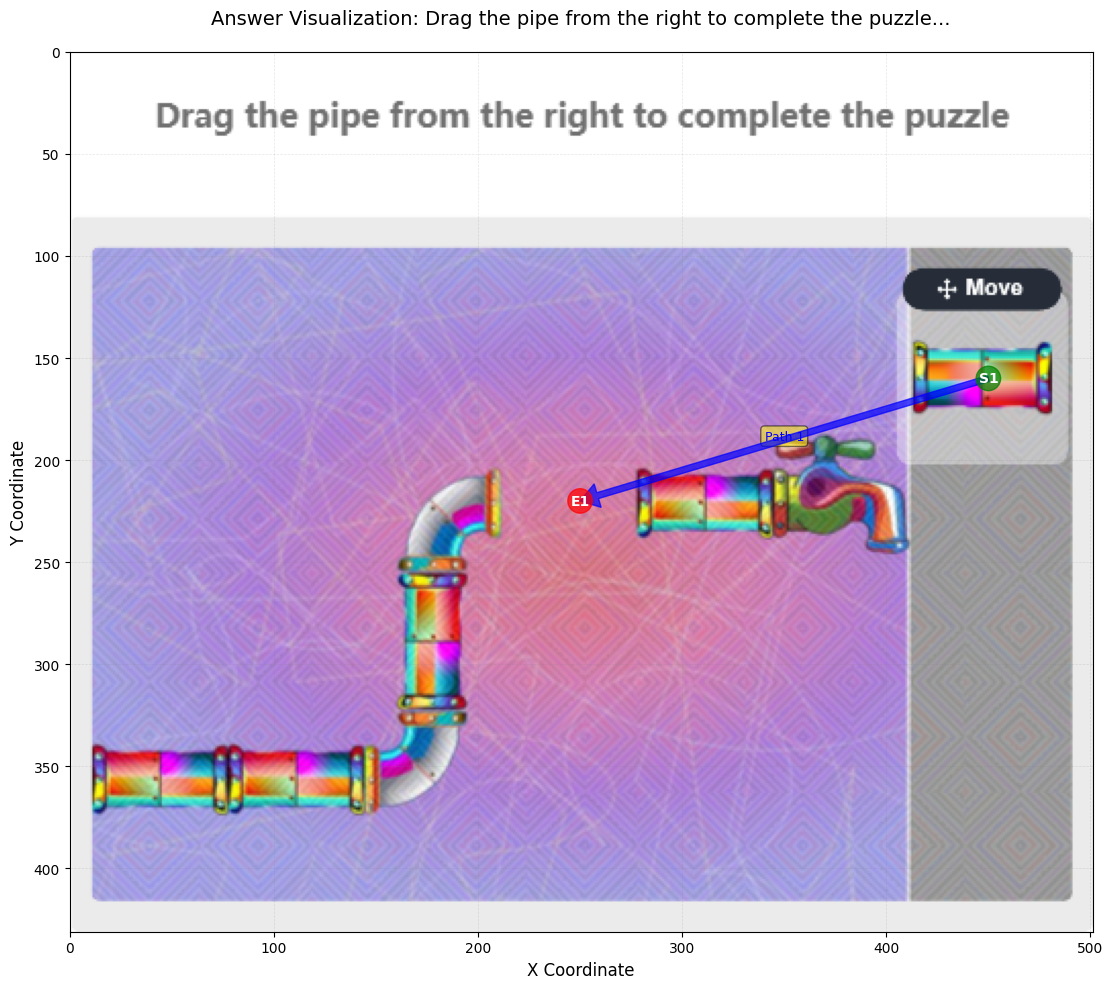

In [5]:
# Check if image exists, otherwise create a sample
if challenge_screenshot.exists():
    # Visualize the answer on the actual image
    result = show_answer_points(
        challenge_screenshot,
        drag_drop_answer,
        DEFAULT_BBOX,
        show_plot=True,
        path_color='blue',
        arrow_width=3,
        alpha=0.7
    )
else:
    print(f"Image not found at {challenge_screenshot}")
    print("Creating a sample image for demonstration...")

    # Create a sample image
    sample_img = np.ones((431, 501, 3), dtype=np.uint8) * 200

    # Visualize on sample image
    result = show_answer_points(
        sample_img,
        drag_drop_answer,
        DEFAULT_BBOX,
        show_plot=True,
        path_color='blue',
        arrow_width=3,
        alpha=0.7
    )

## 2. Image Area Select Challenge Example
Visualize point selections for object identification challenges.

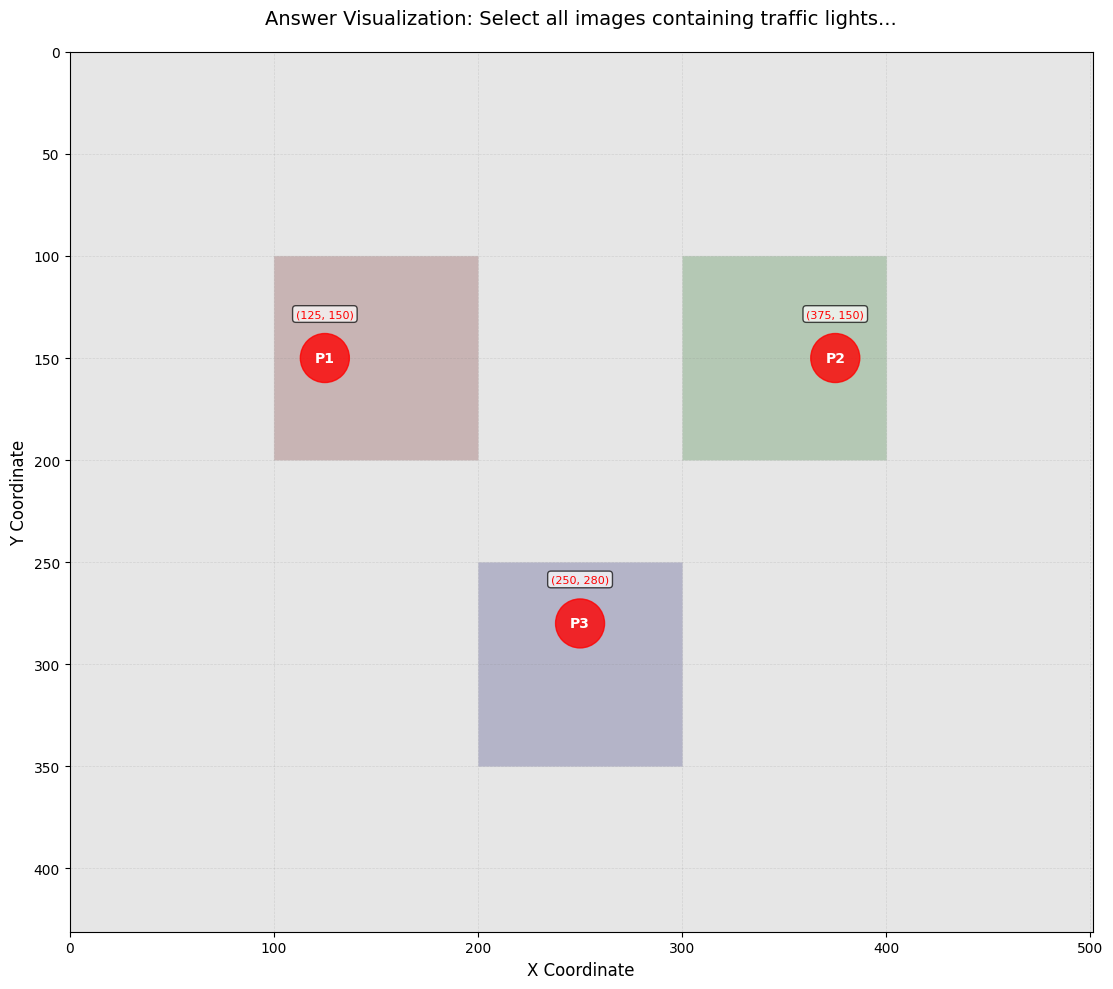

In [6]:
# Example area select answer
area_select_answer = ImageAreaSelectChallenge(
    challenge_prompt="Select all images containing traffic lights",
    points=[
        PointCoordinate(x=125, y=150),
        PointCoordinate(x=375, y=150),
        PointCoordinate(x=250, y=280)
    ]
)

# Create a sample image
sample_img = np.ones((431, 501, 3), dtype=np.uint8) * 230
# Add some variation to make it more realistic
sample_img[100:200, 100:200] = [200, 180, 180]
sample_img[100:200, 300:400] = [180, 200, 180]
sample_img[250:350, 200:300] = [180, 180, 200]

# Visualize the area select points
result = show_answer_points(
    sample_img,
    area_select_answer,
    DEFAULT_BBOX,
    show_plot=True,
    point_color='red',
    point_size=120,
    alpha=0.8
)

## 3. Creating Comparison Views
Compare original challenge image with coordinate grid visualization side by side.

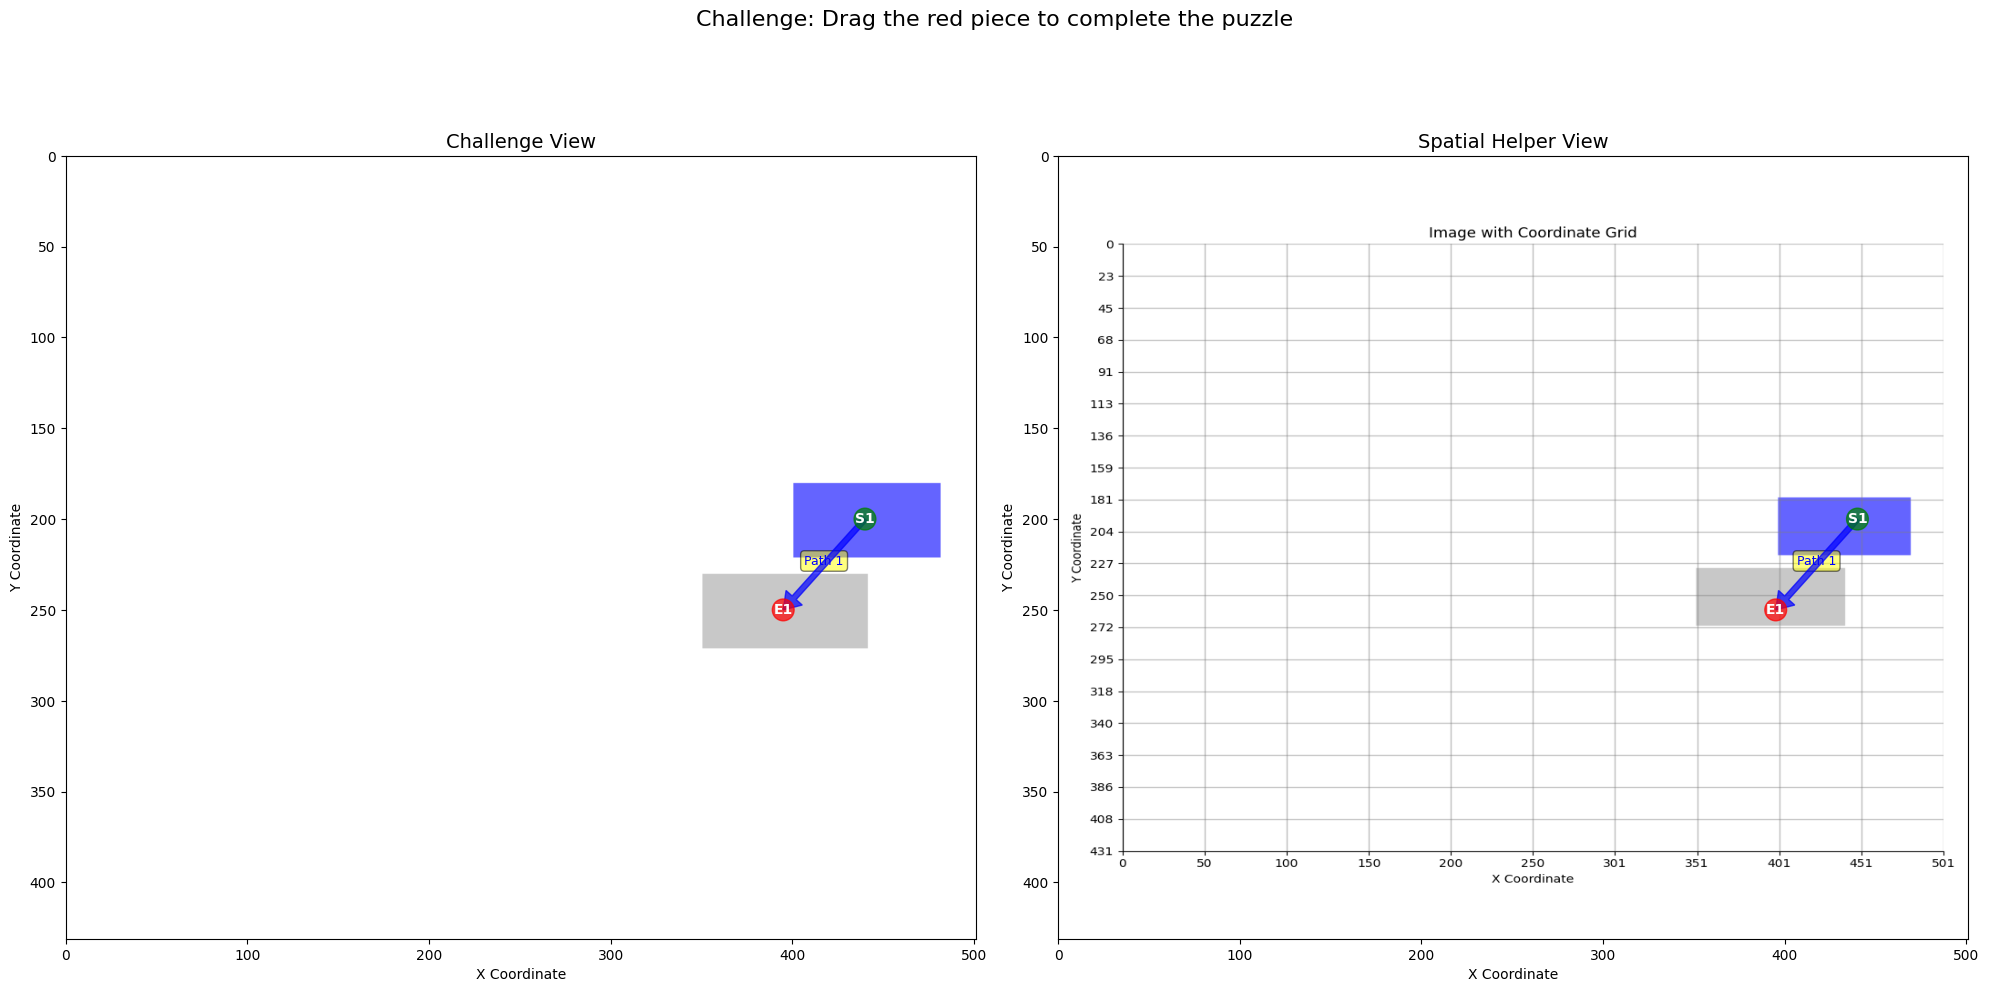

In [7]:
# Create original and coordinate grid images
original_img = np.ones((431, 501, 3), dtype=np.uint8) * 255
# Add some features to the original
cv2.rectangle(original_img, (400, 180), (480, 220), (100, 100, 255), -1)
cv2.rectangle(original_img, (350, 230), (440, 270), (200, 200, 200), -1)

# Create coordinate grid version
coord_img = create_coordinate_grid(
    original_img,
    DEFAULT_BBOX,
    x_line_space_num=11,
    y_line_space_num=20,
    color='gray',
    adaptive_contrast=False
)

# Create drag & drop answer
comparison_answer = ImageDragDropChallenge(
    challenge_prompt="Drag the red piece to complete the puzzle",
    paths=[
        SpatialPath(
            start_point=PointCoordinate(x=440, y=200),
            end_point=PointCoordinate(x=395, y=250)
        )
    ]
)

# Create comparison view
comparison = create_comparison_view(
    original_img,
    coord_img,
    comparison_answer,
    DEFAULT_BBOX
)

## Summary

The `visualize_attention_points` helper provides a flexible way to visualize robot answers on CAPTCHA images:

- **Supports multiple answer types**: Area select points and drag & drop paths
- **Flexible input formats**: Accepts model objects or dictionaries
- **Customizable styling**: Colors, sizes, transparency can be adjusted
- **Comparison views**: Side-by-side visualization of original and coordinate grid
- **Export capabilities**: Save visualizations for documentation or debugging

This tool is essential for:
1. Debugging robot predictions
2. Creating training data visualizations
3. Generating documentation and reports
4. Quality assurance and validation